### Setup

In [2]:
# For maths
import numpy as np
# For separate data sets training/validation
import random

In [3]:
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.3 MB/s eta 0:00:00


In [4]:
# Deep learning library
import torch
import torch.optim as optim

In [5]:
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split

In [6]:
# For progress bars
from tqdm import tqdm

# For plotting graphs
import matplotlib.pyplot as plt

# Misc
import os
import glob

In [7]:
# import files from your Google Drive to Colab
# When you add a new file you have to run this cell again
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
# Check it's connected to Google Drive correctly
import json
with open('/content/drive/My Drive/Leonor/all_patients_data.json', 'r') as file:
    data = json.load(file)

In [16]:
# Train a model, or use an existing one? Change to false if inference only
training_mode = False

# Path to data
# data_path = "/Users/leonorlavina/Desktop/szdata/"
data_path = "/content/drive/My Drive/Leonor/szdata/"

# Location for where to save/load best weights (note that folder should be created already)
weights_path = "best_weights.pth"


In [17]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.1+cu118
Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Using device: cpu


## Preprocess

##### Convert Baseline Data

In [1]:
colab_path = '/content/drive/My Drive/Leonor'

In [18]:
# Get list of all interictal (baseline) files

interictal_paths = glob.glob(os.path.join ('/content/drive/My Drive/Leonor/szdata/' "**/*Baseline.EDF"), recursive=True)

# Remove warnings when loading data
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# Load and concatenate data from multiple files
raw_list = []
for file_path in interictal_paths:
    # print("Reading data from:", file_path)
    raw_list.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))

# raw_list: [(97, 33024), (97, 33024),(97, 33024), ..., (97, 33024)] (len = 90)

print("Total number of raw data:", len(raw_list))
# Save ictal_raw_list in Google Drive
import pickle
raw_list_path = f"{colab_path}/raw_list.pkl"

with open(raw_list_path, 'wb') as file:
    pickle.dump(raw_list, file)

Total number of raw data: 90


###### Get raw_dict with patient_id as key

In [ ]:
interictal_paths = glob.glob(os.path.join ('/content/drive/My Drive/Leonor/szdata/' "**/*Baseline.EDF"), recursive=True)

# Remove warnings when loading data
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# Load and concatenate data from multiple files
raw_dict = {}
for file_path in interictal_paths:

    # print("Reading data from:", file_path)
    raw_list.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))

# raw_list: [(97, 33024), (97, 33024),(97, 33024), ..., (97, 33024)] (len = 90)

print("Total number of raw data:", len(raw_list))
# Save ictal_raw_list in Google Drive
import pickle
raw_list_path = f"{colab_path}/raw_list.pkl"

with open(raw_list_path, 'wb') as file:
    pickle.dump(raw_list, file)

Total number of raw data: 180


##### Load raw_list

In [13]:
# Load ictal_raw_list
import pickle
ictal_raw_list_path = f"{colab_path}/ictal_raw_list.pkl"

with open(ictal_raw_list_path, 'rb') as file:
    ictal_raw_list = pickle.load(file)

print(ictal_raw_list)

[<RawEDF | KiCl_Seizure1.EDF, 60 x 49152 (96.0 s), ~22.6 MB, data loaded>, <RawEDF | KiCl_Seizure2.EDF, 60 x 62208 (121.5 s), ~28.5 MB, data loaded>, <RawEDF | KiCl_Seizure3.EDF, 60 x 47104 (92.0 s), ~21.6 MB, data loaded>, <RawEDF | RhKe_Seizure3.EDF, 146 x 123008 (120.1 s), ~137.2 MB, data loaded>, <RawEDF | RhKe_Seizure2.EDF, 146 x 126080 (123.1 s), ~140.6 MB, data loaded>, <RawEDF | RhKe_Seizure1.EDF, 146 x 140032 (136.7 s), ~156.1 MB, data loaded>, <RawEDF | ArRy_Seizure2.EDF, 117 x 77056 (75.2 s), ~68.9 MB, data loaded>, <RawEDF | ArRy_Seizure3.EDF, 117 x 110080 (107.5 s), ~98.4 MB, data loaded>, <RawEDF | ArRy_Seizure1.EDF, 117 x 96000 (93.7 s), ~85.8 MB, data loaded>, <RawEDF | SaIs_Seizure2.EDF, 59 x 164352 (160.5 s), ~74.0 MB, data loaded>, <RawEDF | SaIs_Seizure3.EDF, 59 x 119296 (116.5 s), ~53.8 MB, data loaded>, <RawEDF | SaIs_Seizure1.EDF, 59 x 109056 (106.5 s), ~49.2 MB, data loaded>, <RawEDF | PoSa_Seizure3.EDF, 123 x 155008 (151.4 s), ~145.6 MB, data loaded>, <RawEDF |

### Calculate Baseline Dataset statistics

In [12]:
# Initialise counters
global_mean = 0
global_var = 0
global_count = 0

# For each file, update the running mean and variance
for raw_data in raw_list:
    data = raw_data.get_data()
    print("data", data.shape)
    n = data.shape[1]
    # print("number of data points:", n)
    local_mean = np.mean(data)
    local_var = np.var(data)

    # Welford's method for updating mean and variance
    delta = local_mean - global_mean
    global_mean += delta * n / (global_count + n)
    global_var += local_var * n + delta**2 * global_count * n / (global_count + n)
    global_count += n

# print("data:", data)

# Finalize the variance and compute standard deviation
global_var /= global_count
global_std = np.sqrt(global_var)
print("global_mean", global_mean)
print("global_std", global_std)


NameError: ignored

### Define SEEGDataset

In [ ]:
%%capture
from typing import List

class SEEGDataset(Dataset):
    def __init__(self, raw, fs:int, mean:float, std:float, epoch_dur:int=1, bandpass:List[int]=[5, 50]):
        """
        SEEGDataset constructor.

        Parameters:
        - raw : Raw instance from MNE
            The raw EEG data.
        - fs : int
            Desired sampling frequency.
        - mean : float
            Mean value for normalization.
        - std : float
            Standard deviation value for normalization.
        - epoch_dur : int, optional
            Duration of each epoch/window. Default is 1.
        - bandpass : list of int, optional
            The frequency range for bandpass filter. Default is [5, 50].
        - inference_mode : bool, optional
            Flag to determine if the dataset is used for training or inference. Default is False.
        """

        # Filter out channels containing the string "Ref"
        picks = [chan for chan in raw.info['ch_names'] if "Ref" not in chan]

        # Retain only the channels in the "picks" list
        raw.pick(picks, verbose=False)

        # Reduce the number of time steps:
        # Apply notch and bandpass filters, and resample the data
        """
        Notch Filter: designed to remove specific frequency bands in this case 50Hz
         - used to remove noise introduced from the electrical systems.
        Bandpass Filter: Frequencies outside of the 5Hz to 50Hz range will be attenuated.
        """
        notch_filters = np.arange(50, bandpass[1], 50)
        if len(notch_filters) > 0:
            raw.notch_filter(notch_filters, picks=picks, filter_length='auto', phase='zero', verbose=False)
        raw.filter(bandpass[0], bandpass[1], fir_design='firwin', verbose=False)
        raw.resample(fs, npad="auto")
        print("filtered raw", raw.get_data().shape)
        # Initialise instance variables
        self.raw = raw
        self.mean = mean
        self.std = std
        self.epoch_dur = epoch_dur
        self.windows = self._create_windows()

    def __len__(self):
        """
        Returns the total number of channel-window combinations.
        """
        return len(self.windows) * len(self.raw.info['ch_names'])

    def __getitem__(self, idx):
        """
        Return data for a given index.

        Parameters:
        - idx : int
            The index to retrieve data.

        Returns:
        - tensor : torch.Tensor
            The EEG data for the given index.
        """
        # which channel to pick from
        channel_idx = idx // len(self.windows)
        # which time window to pick
        window_idx = idx % len(self.windows)
        win_start, win_end = self.windows[window_idx]
        # get the data
        X = self.raw.get_data(picks=channel_idx, start=win_start, stop=win_end)
        # normalize the data
        X = (X - self.mean) / self.std
        return torch.tensor(X, dtype=torch.float32)

    def _create_windows(self):
        """
        Create windows based on the specified epoch duration.

        Returns:
        - windows : list of tuple
            List of (start, end) sample tuples for each window.
        """
        win_len = int(self.epoch_dur * self.raw.info['sfreq'])
        starts = np.arange(0, len(self.raw.times) - win_len, win_len)
        ends = starts + win_len
        windows = list(zip(starts, ends))
        # print("windows", windows)
        return windows


In [ ]:
# raw_list: [np.array(97, 33024), np.array(97, 33024), np.array(97, 33024), ..., np.array(97, 33024)]
# raw_list: np.array(90, 97, 33024)

# raw_list
# dataset = SEEGDataset(raw, 512, mean=global_mean, std=global_std)

### Create patient_loaders

In [ ]:
# local_path = "/Users/leonorlavina/Desktop"
colab_path = "/content/drive/My Drive/Leonor"

total_folders = len(os.listdir(f'{colab_path}/szdata/'))
num_validation = int(0.2 * total_folders)

val_patient_data_baseline = {}
train_patient_data_baseline = {}

# Counter for folders processed
counter = 0

for patient_folder in os.listdir(f'{colab_path}/szdata/'):
    full_path = os.path.join(f'{colab_path}/szdata/', patient_folder)
    print("Getting folders for", patient_folder)
    if os.path.isdir(full_path):
        patient_code_name = patient_folder
        edf_paths = glob.glob(os.path.join(full_path, "*.EDF"))
        raw_list = []
        for file_path in edf_paths:
            if "Baseline" not in file_path:
                continue
            raw_list.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))

        # Custom data set for patient
        dataset = []
        for raw in raw_list:
            dataset.append(SEEGDataset(raw, fs=512, mean=global_mean, std=global_std, epoch_dur=1, bandpass=[5, 50]))

        # Concatenate these datasets
        concatenated_dataset = ConcatDataset(dataset)

        # Create Dataloader for patient
        patient_loader = DataLoader(concatenated_dataset, batch_size=32, shuffle=True)

        # Deterministically assign this patient to training or validation set based on the counter
        if counter < num_validation:
            val_patient_data_baseline[patient_code_name] = patient_loader
        else:
            train_patient_data_baseline[patient_code_name] = patient_loader

        # Increment the counter
        counter += 1

Getting folders for KiCl
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (60, 18176)
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (60, 18176)
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (60, 18176)
Getting folders for RhKe
filtered raw (146, 17024)
filtered raw (146, 17024)
filtered raw (146, 17024)
Getting folders for ArRy
filtered raw (117, 17024)
filtered raw (117, 17024)
filtered raw (117, 17024)
Getting folders for SaIs
filtered raw (59, 17152)
filtered raw (59, 17152)
filtered raw (59, 16640)
Getting folders for PoSa
filtered raw (123, 16512)
filtered raw (123, 16512)
filtered raw (123, 16512)
Getting folders for JaCo
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (58, 18432)
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (58, 17408)
Sampling frequency of the instance is alr

In [ ]:
print("patients part of validation", val_patient_data_baseline.keys())
print("patients part of training", train_patient_data_baseline.keys())

patients part of validation dict_keys(['KiCl', 'RhKe', 'ArRy', 'SaIs', 'PoSa', 'JaCo'])
patients part of training dict_keys(['TiPe', 'MaBo', 'FaCl', 'IsTa', 'FlRe', 'JoDa', 'JeDo', 'ErMcSt', 'BeNe', 'SoBe', 'RuBa', 'ZaSa', 'JoSk', 'EsCh', 'ChSe', 'UzRa', 'BlMo', 'MaMa', 'ChCr', 'KeVe', 'JoHa', 'MiWa', 'SaKh', 'SeHu'])


In [ ]:
for patient_code_name, patient_loader in train_patient_data.items():
    print(f"{patient_code_name}")
    print("number of batches:", len(patient_loader))
    first_batch = next(iter(patient_loader))
    # print("shape of the batch", first_batch.shape) # (num_batches, 1, window_size)
    # print("shape of the data", first_batch[0].shape) # (1, window_size)
print(train_patient_data.keys())

NameError: ignored

### Split Train & Val

In [10]:
# split between training and validation

def split_data(data_path, pattern="**/*Baseline.EDF", train_len=0.8):
    file_paths = glob.glob(os.path.join(data_path, pattern), recursive=True)
    all_train_datasets = []
    all_val_datasets = []

    for file_path in file_paths:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        dataset = SEEGDataset(raw, 512, mean=global_mean, std=global_std)
        # print("dataset.raw.shape", dataset.raw.get_data().shape)
        # print("len(dataset)", len(dataset))
        train_size = int(train_len * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        # print("train_dataset.shape", len(train_dataset))
        # print("val_dataset.shape", len(val_dataset))

        all_train_datasets.append(train_dataset)
        all_val_datasets.append(val_dataset)

    print("len(all_train_datasets)", len(all_train_datasets))
    print("len(all_val_datasets)", len(all_val_datasets))

    train_dataset_combined = ConcatDataset(all_train_datasets)
    val_dataset_combined = ConcatDataset(all_val_datasets)

    train_loader = DataLoader(train_dataset_combined, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset_combined, batch_size=32)

    return train_loader, val_loader


train_loader, val_loader = split_data(data_path, pattern="**/*Baseline.EDF", train_len=0.8)
print("number of training batches:", len(train_loader))
print("number of validation batches:", len(val_loader))

NameError: ignored

In [ ]:
# Checkout how the inputs look like
first_batch = next(iter(train_loader))
print("shape of the batch", first_batch.shape) # (num_batches, 1, window_size)
print("shape of the data", first_batch[0].shape) # (1, window_size)

shape of the batch torch.Size([32, 1, 512])
shape of the data torch.Size([1, 512])


## Training

### Define AnomalyDetector

In [8]:
class AnomalyDetector(nn.Module):
    """
    A simple convolutional autoencoder model for anomaly detection.
    Autoencoders aim to reconstruct their input data.
    """
    def __init__(self, input_channels):
        super(AnomalyDetector, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(16, 8, kernel_size=5, stride=2, padding=2)
        self.deconv1 = nn.ConvTranspose1d(8, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(16, input_channels, kernel_size=5, stride=2, padding=2, output_padding=1)

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward pass through the model.
        Parameters:
        - x (torch.Tensor): Input tensor.
        Returns:
        - x (torch.Tensor): Reconstructed output tensor with shape (6, 1, 512)
        """
        # Encoder
        x = self.relu(self.conv1(x))  # First convolutional layer with ReLU activation
        x = self.dropout(x)           # Dropout to introduce regularization
        x = self.relu(self.conv2(x))  # Second convolutional layer with ReLU activation
        x = self.dropout(x)           # Another dropout

        # Decoder
        x = self.relu(self.deconv1(x))  # First deconvolutional layer with ReLU activation
        x = self.dropout(x)             # Dropout before the final layer
        x = self.deconv2(x)             # Second deconvolutional layer

        return x


### Training AnomalyDetector

In [9]:
import glob

# Initialise the model and move it to the desired device (CPU/GPU)
model = AnomalyDetector(input_channels=1).to(device)

# If training a model, do so, and either way load a model from pre-specified path
if training_mode:

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100  # Increase max epochs as early stopping will halt training once no improvement is seen

    # Lists to keep track of training and validation losses
    train_losses = []
    val_losses = []

    # Variables for early stopping
    patience = 5  # Number of epochs to wait before stopping training if no improvement
    n_bad_epochs = 0  # Counter for epochs without improvement
    best_val_loss = float('inf')  # Set initial best validation loss to infinity

    # Training and validation loop
    for epoch in range(num_epochs):

        # --- Training Phase ---
        model.train()
        train_loss_epoch = []

        train_loader, val_loader = split_data(data_path, pattern="**/*Baseline.EDF", train_len=0.8)
        # Loop over each batch in the training DataLoader
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", position=0, leave=True):
            inputs = batch.to(device)  # Move input data to device

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss_epoch.append(loss.item())

        # Compute and store the average training loss for the epoch
        avg_train_loss = sum(train_loss_epoch) / len(train_loss_epoch)
        train_losses.append(avg_train_loss)
        print()

        # --- Validation Phase ---

        model.eval()  # Set the model to evaluation mode
        val_loss_epoch = []

        # Loop over each batch in the validation DataLoader
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", position=0, leave=True):
                inputs = batch.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss_epoch.append(loss.item())

        avg_val_loss = sum(val_loss_epoch) / len(val_loss_epoch)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # --- Early Stopping Check ---

        # Compute and store the average validation loss for the epoch
        if avg_val_loss < best_val_loss:
            # Save the best model weights
            torch.save(model.state_dict(), weights_path)
            best_val_loss = avg_val_loss
            n_bad_epochs = 0  # Reset counter
        else:
            n_bad_epochs += 1

        if n_bad_epochs >= patience:
            print("Early stopping triggered!")
            break  # Stop training

# Load the saved weights, regardless of whether or not a new model was trained
model.load_state_dict(torch.load(weights_path))

NameError: ignored

### Load model

In [ ]:
# Given that we have already trained the model there's no need to retrain
model_weights_path = f"{colab_path}/best_weights.pth"

# Create an instance of the model
model = AnomalyDetector(input_channels=1).to(device)

# Load the saved weights into the model
weights = torch.load(model_weights_path, map_location=device)
model.load_state_dict(weights)

# Make sure you switch the model to evaluation mode if you're performing inference
model.eval()

AnomalyDetector(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(16, 8, kernel_size=(5,), stride=(2,), padding=(2,))
  (deconv1): ConvTranspose1d(8, 16, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
  (deconv2): ConvTranspose1d(16, 1, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

## Calculate Thresholds

##### Calculate patient_thresholds

In [ ]:
# Initialise a dictionary to store the thresholds
patient_thresholds = {}

criterion = nn.MSELoss()

# Initialize a counter for patient number
patient_number = 1

# Loop through each patient's data
for patient_id, patient_loader in train_patient_data_baseline.items():
    train_mses = []

    # Loop through each batch to calculate MSE for this patient
    for batch in patient_loader:
        # batch: [32, 1, 512]
        inputs = batch.to(device) # Move input data to device
        outputs = model(inputs)
        mse = criterion(outputs, inputs).item()
        train_mses.append(mse)

    # Calculate mean and standard deviation of MSE for this patient
    mean_train_mse = np.mean(train_mses)
    std_train_mse = np.std(train_mses)
    # print("mean_train_mse", mean_train_mse)
    # print("std_train_mse", std_train_mse)

    # Calculate the anomaly threshold for this patient
    threshold_multiplier = 1.5  # This value is not yet fixed
    anomaly_threshold = mean_train_mse + threshold_multiplier * std_train_mse

    # Store the threshold
    patient_thresholds[patient_id] = anomaly_threshold

    # Print the threshold for this patient
    print(f"Anomaly Threshold for patient {patient_id}: {anomaly_threshold}")

    # Increment the patient_number counter
    patient_number += 1


Anomaly Threshold for patient TiPe: 0.006915631116431044
Anomaly Threshold for patient MaBo: 0.00123087927852049
Anomaly Threshold for patient FaCl: 0.011862765644360363
Anomaly Threshold for patient IsTa: 0.0037287790235537724
Anomaly Threshold for patient FlRe: 0.002684343661826155
Anomaly Threshold for patient JoDa: 0.005172092700191402
Anomaly Threshold for patient JeDo: 0.010948223324445122
Anomaly Threshold for patient ErMcSt: 0.013483289020214857
Anomaly Threshold for patient BeNe: 0.0010994024492173527
Anomaly Threshold for patient SoBe: 0.014074633396716416
Anomaly Threshold for patient RuBa: 0.006775974124999743
Anomaly Threshold for patient ZaSa: 0.0030981160107576996
Anomaly Threshold for patient JoSk: 0.0024614480768842726
Anomaly Threshold for patient EsCh: 0.013589975810302964
Anomaly Threshold for patient ChSe: 0.03427610557414297
Anomaly Threshold for patient UzRa: 0.0110675449853577
Anomaly Threshold for patient BlMo: 0.0015376122459556335
Anomaly Threshold for patien

In [ ]:
# Save patient_thresholds in Google Drive
import pickle
patient_thresholds_path = f"{colab_path}/patient_thresholds.pkl"

with open(patient_thresholds_path, 'wb') as file:
    pickle.dump(patient_thresholds, file)

##### Load patient_thresholds

In [ ]:
# If we have already calculate the patient_thresholds we can load it directly from Google Drive
import pickle

patient_thresholds_path = f"{colab_path}/patient_thresholds.pkl"

with open(patient_thresholds_path, 'rb') as file:
    patient_thresholds = pickle.load(file)

print(patient_thresholds)

{'TiPe': 0.04951544862952203, 'MaBo': 0.07444218625931995, 'FaCl': 0.055041392105266804, 'IsTa': 0.24796370678986174, 'FlRe': 0.0444590190702732, 'JoDa': 0.004167069012315195, 'JeDo': 0.02681832042157916, 'ErMcSt': 0.07960168099266675, 'BeNe': 0.01132915392389406, 'SoBe': 0.0805603663656935, 'RuBa': 0.3652189308743852, 'ZaSa': 0.00839969710540451, 'JoSk': 0.15820192686466794, 'EsCh': 0.05441049115345445, 'ChSe': 0.34579429950430973, 'UzRa': 0.14295148964813129, 'BlMo': 0.003421873812286872, 'MaMa': 0.16245260033295209, 'ChCr': 0.22692827669357876, 'KeVe': 0.02961429106340344, 'JoHa': 0.04284851108374454, 'MiWa': 0.045109631015012606, 'SaKh': 0.004672657885686856, 'SeHu': 0.251628813008566}


##### Load manual labels

In [ ]:
# importing manual labels
import json

with open(f'{colab_path}/new_all_patients_data.json', 'r') as file:
    data = json.load(file)

# print(data)

# print("{")
# for key, value in data.items():
#     print(f"    '{key}': {{")
#     for sub_key, sub_value in value.items():
#         items = ', '.join([f"'{item}'" for item in sub_value])
#         print(f"        '{sub_key}': [{items}],")
#     print("    }")

# print("}")


In [ ]:
loaded_data = {}
for patient_id, patient_labels in data.items():
    loaded_data[patient_id] = []
    for label, values in patient_labels.items():
        loaded_data[patient_id].extend(values)
    loaded_data[patient_id] = set(loaded_data[patient_id])

print("}")
for patient_id, true_seizure_channels in loaded_data.items():
     print(f"    '{patient_id}': {true_seizure_channels}")
print("}")

}
    'ArRy': {'EEG F9-F8', 'EEG F2-F1', 'EEG G3-G1', 'EEG E17-E16', 'EEG E16-E15', 'EEG F4-F3', 'EEG G3-G2', 'EEG E14-E13', 'EEG E13-E12', 'EEG F8-F7', 'EEG F7-F6', 'EEG O3-O2', 'EEG F10-F9', 'EEG F5-F4'}
    'BeNe': {'EEG J2-J1', 'EEG K2-K1', 'EEG L8-L7', 'EEG L9-L8'}
    'BiMo': {'EEG M1-Pins1-2', 'EEG SFG-Ains1-3', 'EEG M1-Pins4-M1-Pins3', 'EEG MFG-ACing10-MFG-ACing9', 'EEG AntL3-AntL2', 'EEG MFG-ACing8-MFG-ACing7', 'EEG MFG-ACing9-MFG-ACing8', 'EEG MFG-ACing7-MFG-ACing6', 'EEG AntL5-AntL4', 'EEG AntL4-AntL3', 'EEG SFG-AIns1-2'}
    'ChCr': {'EEG H5-H4', 'EEG I8-I1', 'EEG E7-E6', 'EEG P12-P8', 'EEG Q16-Q1', 'EEG E4-E3', 'EEG E3-E2', 'EEG P11-P10', 'EEG E2-E1', 'EEG P10-P9', 'EEG J15-J1', 'EEG E8-E7', 'EEG P8-P1', 'EEG H3-H2', 'EEG E6-E5', 'EEG P12-P11'}
    'ChSe': {'EEG F2-F1', 'EEG C2-C1', 'EEG D4-D1', 'EEG C5-C3', 'EEG D3-D2', 'EEG B10-B5', 'EEG B4-B1', 'EEG D4-D3'}
    'ErMcSt': {'EEG H7-H6', 'EEG G3-G2', 'EEG C8-C7', 'EEG H6-H5', 'EEG G4-G3', 'EEG E6-E5', 'EEG F2-F1', 'EEG E7-

In [ ]:
print("}")
for patient_id, patient_loader in val_patient_data.items():
    print(f"{patient_id}")
    print("number of batches:", len(patient_loader))
    first_batch = next(iter(patient_loader))
    print("shape of the batch", first_batch.shape) # (num_batches, 1, window_size)
    print("shape of the data", first_batch[0].shape) # (1, window_size)

}


NameError: ignored

### Preprocess Seizure Data


#### All data

##### Convert ictal data

In [ ]:
import glob

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install mne
import mne

colab_path = "/content/drive/My Drive/Leonor"

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.3 MB/s eta 0:00:00


In [ ]:
import os
data_path = "/content/drive/My Drive/Leonor/szdata/"
# Load ictal EDF files
all_edf_paths = glob.glob(os.path.join(data_path, '**/*.EDF'), recursive=True)
# Get all the paths of the Non-Baseline files
ictal_paths = []
for path in all_edf_paths:
    if "Baseline" not in path:
        ictal_paths.append(path)

# Remove warnings when loading data
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# Create raw list for ictal data
ictal_raw_list = []
for file_path in ictal_paths:
    ictal_raw_list.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))

# Save ictal_raw_list in Google Drive
import pickle
ictal_raw_list_path = f"{colab_path}/ictal_raw_list.pkl"

with open(ictal_raw_list_path, 'wb') as file:
    pickle.dump(ictal_raw_list, file)

##### Load ictal_raw_list

In [ ]:
# Load ictal_raw_list
import pickle
ictal_raw_list_path = f"{colab_path}/ictal_raw_list.pkl"

with open(ictal_raw_list_path, 'rb') as file:
    ictal_raw_list = pickle.load(file)

print(ictal_raw_list)

[<RawEDF | KiCl_Seizure1.EDF, 60 x 49152 (96.0 s), ~22.6 MB, data loaded>, <RawEDF | KiCl_Seizure2.EDF, 60 x 62208 (121.5 s), ~28.5 MB, data loaded>, <RawEDF | KiCl_Seizure3.EDF, 60 x 47104 (92.0 s), ~21.6 MB, data loaded>, <RawEDF | RhKe_Seizure3.EDF, 146 x 123008 (120.1 s), ~137.2 MB, data loaded>, <RawEDF | RhKe_Seizure2.EDF, 146 x 126080 (123.1 s), ~140.6 MB, data loaded>, <RawEDF | RhKe_Seizure1.EDF, 146 x 140032 (136.7 s), ~156.1 MB, data loaded>, <RawEDF | ArRy_Seizure2.EDF, 117 x 77056 (75.2 s), ~68.9 MB, data loaded>, <RawEDF | ArRy_Seizure3.EDF, 117 x 110080 (107.5 s), ~98.4 MB, data loaded>, <RawEDF | ArRy_Seizure1.EDF, 117 x 96000 (93.7 s), ~85.8 MB, data loaded>, <RawEDF | SaIs_Seizure2.EDF, 59 x 164352 (160.5 s), ~74.0 MB, data loaded>, <RawEDF | SaIs_Seizure3.EDF, 59 x 119296 (116.5 s), ~53.8 MB, data loaded>, <RawEDF | SaIs_Seizure1.EDF, 59 x 109056 (106.5 s), ~49.2 MB, data loaded>, <RawEDF | PoSa_Seizure3.EDF, 123 x 155008 (151.4 s), ~145.6 MB, data loaded>, <RawEDF |

In [ ]:
print("Number of Non-Baseline files:", len(ictal_raw_list))

Number of Non-Baseline files: 90


#### Patient loader Ictals

In [ ]:
colab_path = "/content/drive/My Drive/Leonor"

total_folders = len(os.listdir(f'{colab_path}/szdata/'))
num_validation = int(0.2 * total_folders)

val_patient_data_seizure = {}
train_patient_data_seizure = {}

# Counter for folders processed
counter = 0

for patient_folder in os.listdir(f'{colab_path}/szdata/'):
    full_path = os.path.join(f'{colab_path}/szdata/', patient_folder)
    # print("Getting folders for", patient_folder)
    if os.path.isdir(full_path):
        patient_code_name = patient_folder
        edf_paths = glob.glob(os.path.join(full_path, "*.EDF"))
        raw_list = []
        for file_path in edf_paths:
            if "Baseline" in file_path:
                continue
            raw_list.append(mne.io.read_raw_edf(file_path, preload=True, verbose=False))

        # Custom data set for patient
        datasets = []
        for raw in raw_list:
            print(raw.get_data().shape)
            dataset = SEEGDataset(raw, fs=512, mean=global_mean, std=global_std, epoch_dur=1, bandpass=[5, 50])
            print(f"Total number of windows: {len(dataset.windows)}")
            print(f"Total samples in the dataset: {len(dataset)}") # num_windows * num_channels
            # shape of sample: (1, 512) (1, window size)
            # print(f"Shape of each sample: {dataset[0].shape}") #
            datasets.append(dataset)

        # Concatenate these datasets
        concatenated_dataset = ConcatDataset(datasets)

        # Create Dataloader for patient
        patient_loader = DataLoader(concatenated_dataset, batch_size=32, shuffle=True)

        # Deterministically assign this patient to training or validation set based on the counter
        if counter < num_validation:
            print(f"Adding {patient_code_name} to validation set")
            val_patient_data_seizure[patient_code_name] = patient_loader
        else:
            print(f"Adding {patient_code_name} to training set")
            train_patient_data_seizure[patient_code_name] = patient_loader

        # Increment the counter
        counter += 1

(60, 49152)
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (60, 49152)
Total number of windows: 95
Total samples in the dataset: 5700
(60, 62208)
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (60, 62208)
Total number of windows: 121
Total samples in the dataset: 7260
(60, 47104)
Sampling frequency of the instance is already 512.0, returning unmodified.
filtered raw (60, 47104)
Total number of windows: 91
Total samples in the dataset: 5460
Adding KiCl to validation set
(146, 123008)
filtered raw (146, 61504)
Total number of windows: 120
Total samples in the dataset: 17520
(146, 126080)
filtered raw (146, 63040)
Total number of windows: 123
Total samples in the dataset: 17958
(146, 140032)
filtered raw (146, 70016)
Total number of windows: 136
Total samples in the dataset: 19856
Adding RhKe to validation set
(117, 77056)
filtered raw (117, 38528)
Total number of windows: 75
Total samples in the dataset: 87

In [ ]:
print(val_patient_data.keys())
print(train_patient_data.keys())

NameError: ignored

### Calculate ictal_mses


* ictal_mses:  error of Anomaly Detection for Seizure data  

##### Statistics on global ictal_mses

In [ ]:
import numpy as np
# Calculate ictal_global_mean and ictal_global_std
ictal_global_mean = 0
ictal_global_var = 0
ictal_global_count = 0

for raw_data in ictal_raw_list:
    data = raw_data.get_data()
    n = data.shape[1]
    local_mean = np.mean(data)
    local_var = np.var(data)

    # Welford's method for updating mean and variance
    delta = local_mean - ictal_global_mean
    ictal_global_mean += delta * n / (ictal_global_count + n)
    ictal_global_var += local_var * n + delta**2 * ictal_global_count * n / (ictal_global_count + n)
    ictal_global_count += n

# Finalize the variance and compute standard deviation
ictal_global_var /= ictal_global_count
ictal_global_std = np.sqrt(ictal_global_var)
print("ictal_global_mean:", ictal_global_mean)
print("ictal_global_std:", ictal_global_std)

ictal_global_mean: -5.859446085949422e-06
ictal_global_std: 0.0002555721539640478


**ictal_global_mean:** -5.859446085949422e-06

**ictal_global_std:** 0.0002555721539640478

##### Calculate ictal_mses

In [ ]:
def convert_to_baseline_path(original_path: str) -> str:
    """
    Convert an EDF file path for a seizure to its corresponding baseline file path.

    Parameters:
    - original_path (str): The original file path for the seizure EDF file.

    Returns:
    - str: The modified file path for the baseline EDF file.
    """

    # Split the original path into directory and file name
    directory, file_name = original_path.rsplit('/', 1)

    # Replace "Seizure" with "Sz" and append "_Baseline" to file name
    modified_file_name = file_name.replace("Seizure", "Sz")[:-4] + "_Baseline.EDF"

    # Combine directory and modified file name to create the new path
    new_path = f"{directory}/{modified_file_name}"

    return new_path

In [ ]:
def load_and_prepare_data(seizure_file, standardise=True):
    """
    Load and prepare data for either MSE calculation or seizure score calculation.
    :param seizure_file: Path to the seizure EDF file.
    :param standardise: Whether to standardise the data based on interictal periods.
    :return: DataLoader, list of channel labels.
    """
    if standardise:
        raw_interictal_file = convert_to_baseline_path(seizure_file)
        raw_interictal = mne.io.read_raw_edf(raw_interictal_file, preload=True, verbose=False)
        interictal_dataset = SEEGDataset(raw_interictal, fs=512, mean=global_mean, std=global_std, epoch_dur=1, bandpass=[5, 50])

    raw = mne.io.read_raw_edf(seizure_file, preload=True, verbose=False)
    dataset = SEEGDataset(raw, fs=512, mean=global_mean, std=global_std, epoch_dur=1, bandpass=[5, 50])

    channel_labels = [chan for chan in raw.info['ch_names'] if "Ref" not in chan]
    data_loader = DataLoader(dataset, batch_size=32)

    return data_loader, channel_labels


def get_mses(seizure_file, model, device, standardise=True):
    """
    Compute the Mean Squared Errors (MSEs) for each sample in the SEEG dataset.
    :param seizure_file: Path to the seizure EDF file.
    :param model: Pretrained PyTorch model.
    :param device: Computational device ('cpu' or 'cuda').
    :param standardise: Whether to standardise the data.
    :return: Array of MSEs, reshaped to (num_channels, num_samples).
    """
    data_loader, channel_labels = load_and_prepare_data(seizure_file, standardise)

    model.eval()
    mses = []
    with torch.no_grad():
        for batch in data_loader: 'Josk'
            inputs = batch
            inputs = inputs.to(device)  # Move input data to device
            outputs = model(inputs)
            mse_batch = np.mean(np.square(inputs.cpu().numpy() - outputs.cpu().numpy()), axis=-1)[:, 0]
            # mse_batch = np.square(inputs.cpu().numpy() - outputs.cpu().numpy())
            mses.extend(mse_batch)

    reshaped_mses = np.array(mses).reshape(len(channel_labels), -1)
    return reshaped_mses, channel_labels

reshaped_mses, channel_labels = get_mses(f"{colab_path}/szdata/JoSk/JoSk_Seizure1.EDF", model, device, standardise=True)

IndentationError: ignored

In [ ]:
print(reshaped_mses.shape)

(117, 93)


In [ ]:
print(channel_labels)

['EEG N10-N9', 'EEG N9-N8', 'EEG N8-N7', 'EEG N7-N6', 'EEG N6-N5', 'EEG N5-N4', 'EEG N4-N3', 'EEG N3-N2', 'EEG N2-N1', 'EEG O9-O8', 'EEG O8-O7', 'EEG O7-O6', 'EEG O6-O5', 'EEG O5-O4', 'EEG O4-O3', 'EEG O3-O2', 'EEG O2-O1', 'EEG G9-G8', 'EEG G8-G7', 'EEG G7-G6', 'EEG G6-G5', 'EEG G5-G4', 'EEG G4-G3', 'EEG G3-G2', 'EEG G2-G1', 'EEG M11-M10', 'EEG M10-M9', 'EEG M9-M8', 'EEG M8-M7', 'EEG M4-M3', 'EEG M3-M2', 'EEG M2-M1', 'EEG F10-F9', 'EEG F9-F8', 'EEG F8-F7', 'EEG F7-F6', 'EEG F6-F5', 'EEG F5-F4', 'EEG F4-F3', 'EEG F3-F2', 'EEG F2-F1', 'EEG H8-H7', 'EEG H7-H6', 'EEG H6-H5', 'EEG H5-H4', 'EEG H4-H3', 'EEG I13-I12', 'EEG I12-I11', 'EEG I11-I10', 'EEG I6-I5', 'EEG I5-I4', 'EEG I4-I3', 'EEG I3-I2', 'EEG I2-I1', 'EEG J8-J7', 'EEG J7-J6', 'EEG J6-J5', 'EEG J5-J4', 'EEG J4-J3', 'EEG J3-J2', 'EEG J2-J1', 'EEG D11-D10', 'EEG D10-D9', 'EEG D9-D8', 'EEG D8-D7', 'EEG D7-D6', 'EEG D6-D5', 'EEG D5-D4', 'EEG D4-D3', 'EEG D3-D2', 'EEG D2-D1', 'EEG C15-C14', 'EEG C14-C13', 'EEG C13-C12', 'EEG C12-C11', 'E

### AUC ROC Score

In [ ]:
def calculate_auc_score(file_path):
    reshaped_mses, channel_labels = get_mses(file_path, model, device, standardise=True)
    seizure_scores = np.max(reshaped_mses, axis=1)
    print(seizure_scores.shape)

    return auc_score

    # FUNCTION FOR roc_auc_score
    from sklearn.metrics import roc_auc_score
    import json

    # Get the patient's seizure channels
    seizure_chans = loaded_data["ArRy"]

    # Create indicator list: 1 if the channel had a seizure, 0 if no seizure
    seizure_indicator = [1 if label in seizure_chans else 0 for label in channel_labels]
    print(seizure_indicator)
    # Calculate ROC AUC score
    print("shape seizure_indicator", np.array(seizure_indicator).shape) # num_channels
    print("shape seizure_scores", seizure_scores.shape) # num_samples
    auc_score = roc_auc_score(seizure_indicator, seizure_scores)

    print("ROC AUC Score:", auc_score)

**ROC AUC TABLE MEAN, SE AND C.I

         Mean ROC-AUC        SE                        Confidence Interval
PATIENT                                                                   
1            0.906667  0.018559   (0.8268128115492223, 0.9865205217841112)
2            0.960000  0.010000   (0.9169734727008871, 1.0030265272991128)
3            0.830000  0.065574   (0.5478561923218663, 1.1121438076781338)
4            0.720000  0.010000   (0.6769734727008873, 0.7630265272991129)
5            0.890000  0.060277   (0.6306484087800752, 1.1493515912199248)
6            0.633333  0.012019   (0.5816218832059659, 0.6850447834607007)
7            0.646667  0.042557    (0.4635580242401093, 0.829775309093224)
8            0.703333  0.029627   (0.5758572867545163, 0.8308093799121502)
9            0.743333  0.103494   (0.2980324490901151, 1.1886342175765514)
10           0.826667  0.008819   (0.7887208363292721, 0.8646124970040612)
11           0.696667  0.012019    (0.6449552165392993, 0.748378116794034)
12           0.820000  0.

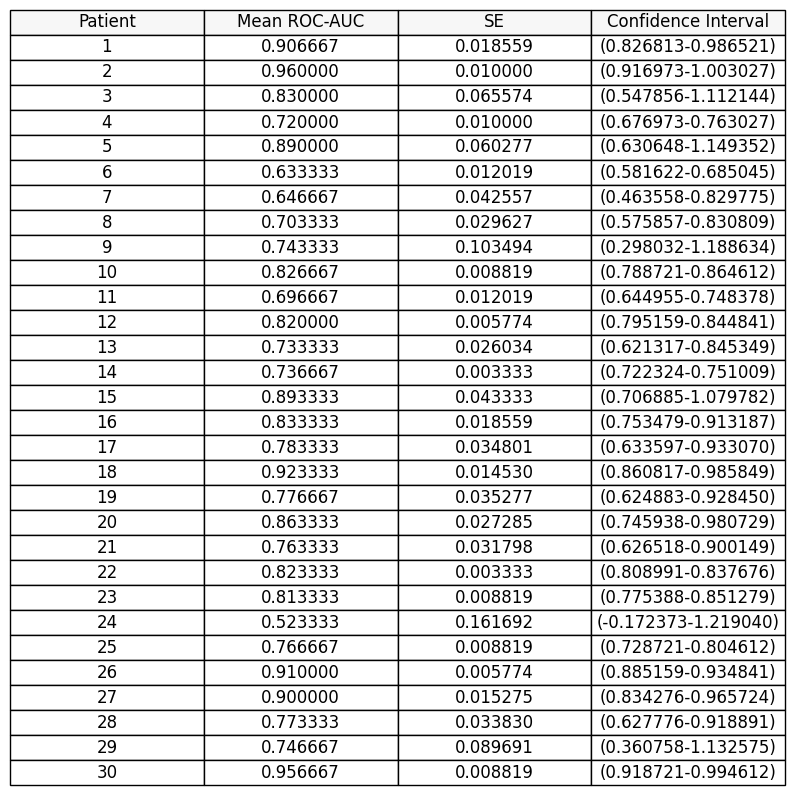

In [74]:
# Import necessary modules
!pip install pandas
!pip install statsmodels
!pip install xlrd

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, anderson
from statsmodels.formula.api import ols



# Load data from Excel
df = pd.read_excel('/content/drive/My Drive/Leonor/RocAuc&Youden.xlsx', sheet_name="Sheet3")


from scipy.stats import t

# Group data by patient and calculate mean and SE
grouped = df.groupby('PATIENT')['ROC-AUC']
mean_auc = grouped.mean()
se_auc = grouped.std() / np.sqrt(grouped.count())

# Calculate confidence intervals (assuming a 95% confidence level)
confidence_level = 0.95
degrees_of_freedom = grouped.count() - 1
margin_of_error = t.ppf((1 + confidence_level) / 2, degrees_of_freedom) * se_auc
confidence_intervals = [(mean - margin, mean + margin) for mean, margin in zip(mean_auc, margin_of_error)]

# Add confidence intervals to a new DataFrame
ci_df = pd.DataFrame({'Mean ROC-AUC': mean_auc, 'SE': se_auc, 'Confidence Interval': confidence_intervals})

print(ci_df)

!pip install tabulate
from tabulate import tabulate

# Assuming you have the 'ci_df' DataFrame with the data
# Extract the data from the DataFrame
data = ci_df.reset_index()

# Create a figure for the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off the axis

# Create a table within the figure
table_data = []
for _, row in data.iterrows():
    patient = row['PATIENT']
    mean_roc_auc = row['Mean ROC-AUC']
    se = row['SE']
    confidence_interval = row['Confidence Interval']

    # Extract the lower and upper bounds from the confidence interval tuple
    lower_bound, upper_bound = confidence_interval

    # Create the row with the desired format
    table_data.append([patient, f"{mean_roc_auc:.6f}", f"{se:.6f}", f"({lower_bound:.6f}-{upper_bound:.6f})"])

# Define headers for the table
headers = ['Patient', 'Mean ROC-AUC', 'SE', 'Confidence Interval']

# Create the table
table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center', colColours=['#f7f7f7']*len(headers))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  # Adjust the scale as needed

# Save the table as an image
plt.savefig('table_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the table as an image (optional)
plt.show()


### Youden Index

In [ ]:
from sklearn.metrics import confusion_matrix

def calculate_youden_for_threshold(labels, predictions, threshold):
    # Convert predictions to binary labels based on the provided threshold
    binarized_predictions = [1 if p >= threshold else 0 for p in predictions]

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(labels, binarized_predictions).ravel()

    # Compute sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    # Compute Youden index
    youden_index = sensitivity + specificity - 1

    return youden_index

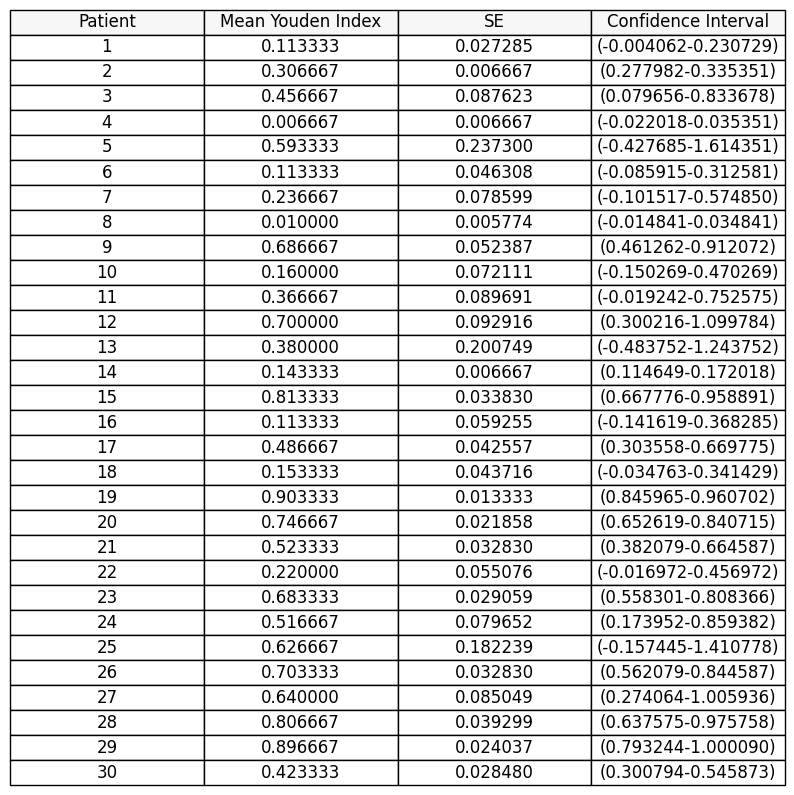

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from Excel
youden_df = pd.read_excel('/content/drive/My Drive/Leonor/RocAuc&Youden.xlsx', sheet_name='Sheet4')

# Calculate Mean Youden Index and Confidence Intervals
grouped = youden_df.groupby('Patient')['Youden Index']
mean_youden = grouped.mean()
se_youden = grouped.std() / np.sqrt(grouped.count())

# Calculate confidence intervals (assuming a 95% confidence level)
confidence_level = 0.95
degrees_of_freedom = grouped.count() - 1
margin_of_error = t.ppf((1 + confidence_level) / 2, degrees_of_freedom) * se_youden
confidence_intervals = [(mean - margin, mean + margin) for mean, margin in zip(mean_youden, margin_of_error)]

# Add Mean Youden Index and Confidence Intervals to a new DataFrame
youden_ci_df = pd.DataFrame({'Mean Youden Index': mean_youden, 'SE': se_youden, 'Confidence Interval': confidence_intervals})

# Create a figure for the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off the axis

# Create a table within the figure
youden_table_data = []
for patient, row in youden_ci_df.iterrows():
    mean_youden = row['Mean Youden Index']
    se = row['SE']
    confidence_interval = row['Confidence Interval']

    # Extract the lower and upper bounds from the confidence interval tuple
    lower_bound, upper_bound = confidence_interval

    # Create the row with the desired format
    youden_table_data.append([patient, f"{mean_youden:.6f}", f"{se:.6f}", f"({lower_bound:.6f}-{upper_bound:.6f})"])

# Define headers for the Youden Index table
youden_headers = ['Patient', 'Mean Youden Index', 'SE', 'Confidence Interval']

# Create the Youden Index table
youden_table = ax.table(cellText=youden_table_data, colLabels=youden_headers, cellLoc='center', loc='center', colColours=['#f7f7f7']*len(youden_headers))

# Style the Youden Index table
youden_table.auto_set_font_size(False)
youden_table.set_fontsize(12)
youden_table.scale(1, 1.5)  # Adjust the scale as needed

# Save the Youden Index table as an image
plt.savefig('youden_table_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)


# Run this Cell

In [ ]:
!pip install mne
import mne

In [ ]:
def convert_to_baseline_path(original_path: str) -> str:
    """
    Convert an EDF file path for a seizure to its corresponding baseline file path.

    Parameters:
    - original_path (str): The original file path for the seizure EDF file.

    Returns:
    - str: The modified file path for the baseline EDF file.
    """

    # Split the original path into directory and file name
    directory, file_name = original_path.rsplit('/', 1)

    # Replace "Seizure" with "Sz" and append "_Baseline" to file name
    modified_file_name = file_name.replace("Seizure", "Sz")[:-4] + "_Baseline.EDF"

    # Combine directory and modified file name to create the new path
    new_path = f"{directory}/{modified_file_name}"

    return new_path

def load_and_prepare_data(seizure_file, standardise=True):
    """
    Load and prepare data for either MSE calculation or seizure score calculation.
    :param seizure_file: Path to the seizure EDF file.
    :param standardise: Whether to standardise the data based on interictal periods.
    :return: DataLoader, list of channel labels.
    """
    if standardise:
        raw_interictal_file = convert_to_baseline_path(seizure_file)
        raw_interictal = mne.io.read_raw_edf(raw_interictal_file, preload=True, verbose=False)
        interictal_dataset = SEEGDataset(raw_interictal, fs=512, mean=global_mean, std=global_std, epoch_dur=1, bandpass=[5, 50])

    raw = mne.io.read_raw_edf(seizure_file, preload=True, verbose=False)
    dataset = SEEGDataset(raw, fs=512, mean=global_mean, std=global_std, epoch_dur=1, bandpass=[5, 50])

    channel_labels = [chan for chan in raw.info['ch_names'] if "Ref" not in chan]
    data_loader = DataLoader(dataset, batch_size=32)

    return data_loader, channel_labels


def get_mses(seizure_file, model, device, standardise=True):
    """
    Compute the Mean Squared Errors (MSEs) for each sample in the SEEG dataset.
    :param seizure_file: Path to the seizure EDF file.
    :param model: Pretrained PyTorch model.
    :param device: Computational device ('cpu' or 'cuda').
    :param standardise: Whether to standardise the data.
    :return: Array of MSEs, reshaped to (num_channels, num_samples).
    """
    data_loader, channel_labels = load_and_prepare_data(seizure_file, standardise)

    model.eval()
    mses = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch
            inputs = inputs.to(device)  # Move input data to device
            outputs = model(inputs)
            mse_batch = np.mean(np.square(inputs.cpu().numpy() - outputs.cpu().numpy()), axis=-1)[:, 0]
            # mse_batch = np.square(inputs.cpu().numpy() - outputs.cpu().numpy())
            mses.extend(mse_batch)

    reshaped_mses = np.array(mses).reshape(len(channel_labels), -1)
    return reshaped_mses, channel_labels

from sklearn.metrics import confusion_matrix

def calculate_youden_for_threshold(labels, predictions, threshold):
    # Convert predictions to binary labels based on the provided threshold
    binarized_predictions = [1 if p >= threshold else 0 for p in predictions]

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(labels, binarized_predictions).ravel()

    # Compute sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    # Compute Youden index
    youden_index = sensitivity + specificity - 1

    return youden_index

def calculate_auc_score(file_path):
    reshaped_mses, channel_labels = get_mses(file_path, model, device, standardise=True)
    seizure_scores = np.max(reshaped_mses, axis=1)
    print(seizure_scores.shape)

    # FUNCTION FOR roc_auc_score
    from sklearn.metrics import roc_auc_score
    import json

    # Get the patient's seizure channels
    seizure_chans = loaded_data["JoSk"]

    # Create indicator list: 1 if the channel had a seizure, 0 if no seizure
    seizure_indicator = [1 if label in seizure_chans else 0 for label in channel_labels]
    print(seizure_indicator)
    # Calculate ROC AUC score
    print("shape seizure_indicator", np.array(seizure_indicator).shape) # num_channels
    print("shape seizure_scores", seizure_scores.shape) # num_samples
    auc_score = roc_auc_score(seizure_indicator, seizure_scores)

    print("ROC AUC Score:", auc_score)
    youden_score = calculate_youden_for_threshold(labels=seizure_indicator, predictions=seizure_scores, threshold=patient_thresholds['ZaSa'])
    print("youden_score:", youden_score)

colab_path = '/content/drive/My Drive/Leonor/'

calculate_auc_score(f"{colab_path}/szdata/JoSk/JoSk_Seizure3.EDF")



filtered raw (44, 17024)
filtered raw (44, 55040)
(44,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
shape seizure_indicator (44,)
shape seizure_scores (44,)


ValueError: ignored

**Plotting Average ROC-AUC score for individual patients **

Takes the average of the ROC-AUC score for the 3 seizures

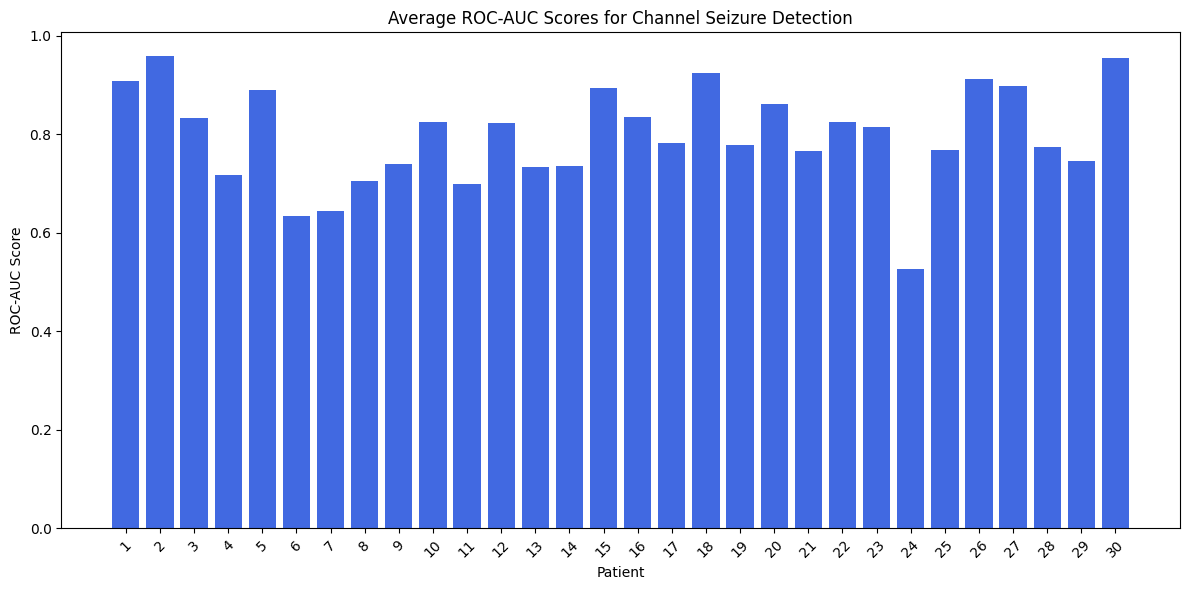

In [ ]:
import matplotlib.pyplot as plt

# Your ROC-AUC scores
roc_auc_scores = [
    0.908037475, 0.959166667, 0.832266976, 0.717585302, 0.89088729, 0.634096063,
    0.644419306, 0.705333333, 0.739763734, 0.824952381, 0.698679008, 0.822419493,
    0.734405458, 0.73513599, 0.893711522, 0.83482634, 0.78286413, 0.924231231,
    0.778645419, 0.861069925, 0.766789863, 0.825248756, 0.815012342, 0.526315789,
    0.768786789, 0.911941971, 0.897189267, 0.774419719, 0.745456753, 0.954809287
]

# Create a list of labels for each score (optional)
labels = [str(i+1) for i in range(len(roc_auc_scores))]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, roc_auc_scores, color='royalblue')
plt.xlabel('Patient')
plt.ylabel('ROC-AUC Score')
plt.title('Average ROC-AUC Scores for Channel Seizure Detection')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()




### Plot graphs for TiPe Baseline

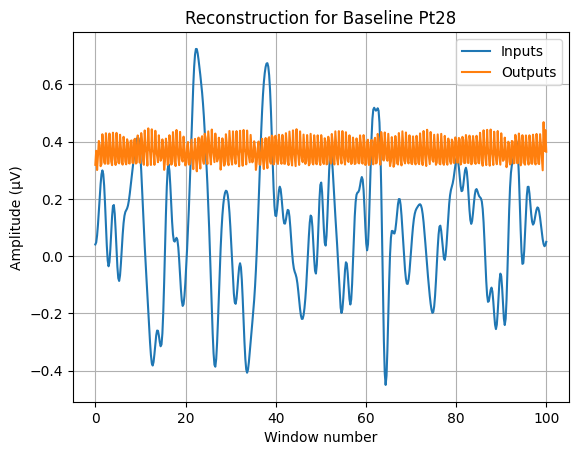

In [ ]:
import matplotlib.pyplot as plt

model.eval()
mse_accumulator = []  # A list to accumulate the MSE for each batch
dataloader = train_patient_data_baseline['TiPe']
with torch.no_grad():
    for batch in dataloader:
        inputs = batch.to(device)  # inputs: (batch_size, num_channels, 512)
        outputs = model(inputs)  # Run the batch through the model.
        break

x = np.linspace(0, 100, 512)
y1 = inputs[4].squeeze()
y2 = outputs[4].squeeze()
plt.plot(x, y1, label="Inputs")
plt.plot(x, y2, label="Outputs")
plt.xlabel('Window number')
plt.ylabel('Amplitude (µV)')
plt.title('Reconstruction for Baseline Pt28')
plt.grid(True)
plt.legend()
plt.show()



### Plot graphs for KiCl Baseline

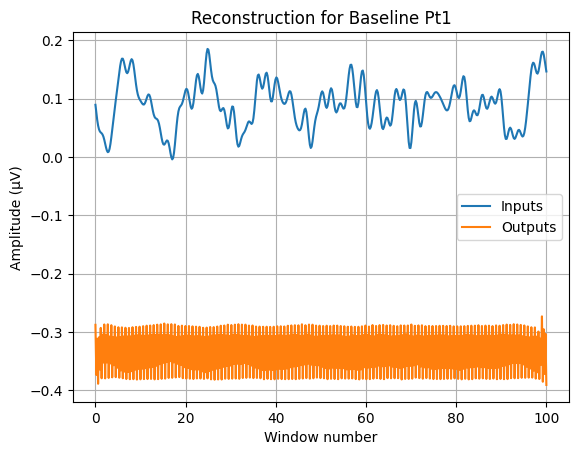

In [ ]:
import matplotlib.pyplot as plt

model.eval()
mse_accumulator = []  # A list to accumulate the MSE for each batch
dataloader = val_patient_data_baseline['ArRy']
with torch.no_grad():
    for batch in dataloader:
        inputs = batch.to(device)  # inputs: (batch_size, num_channels, 512)
        outputs = model(inputs)  # Run the batch through the model.
        break

x = np.linspace(0, 100, 512)
y1 = inputs[4].squeeze()
y2 = outputs[4].squeeze()
plt.plot(x, y1, label="Inputs")
plt.plot(x, y2, label="Outputs")
plt.xlabel('Window number')
plt.ylabel('Amplitude (µV)')
plt.title('Reconstruction for Baseline Pt1')
plt.grid(True)
plt.legend()
plt.show()

### Plot graphs for KiCl Seizure

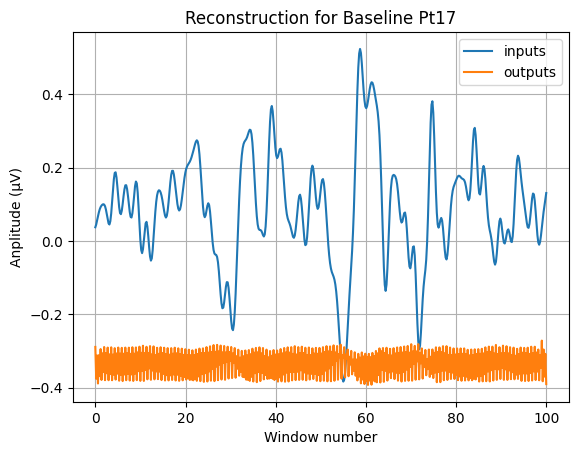

In [ ]:
import matplotlib.pyplot as plt

model.eval()
mse_accumulator = []  # A list to accumulate the MSE for each batch
dataloader = val_patient_data_seizure['KiCl']
with torch.no_grad():
    for batch in dataloader:
        inputs = batch.to(device)  # inputs: (batch_size, num_channels, 512)
        outputs = model(inputs)  # Run the batch through the model.
        break

x = np.linspace(0, 100, 512)
y1 = inputs[4].squeeze()
y2 = outputs[4].squeeze()
plt.plot(x, y1, label="inputs")
plt.plot(x, y2, label="outputs")
plt.xlabel('Window number')
plt.ylabel('Anplitude (µV)')
plt.title('Reconstruction for Baseline Pt17')
plt.grid(True)
plt.legend()
plt.show()

### Plot graphs for ArRy Seizure

In [ ]:
# Path to seizure file (from data directory) to visualise
seizure_file = data_path + "SeHu/SeHu_Seizure3.EDF"

# Load EEG data from an EDF file
raw = mne.io.read_raw_edf(seizure_file, preload=True, verbose=False)

# Filter out the reference channels and extract channel labels
channel_labels = [chan[4:] for chan in raw.info['ch_names'] if "Ref" not in chan]

# Create an EEG dataset for inference
dataset = SEEGDataset(raw, 512, mean=global_mean, std=global_std)
data_loader = DataLoader(dataset, batch_size=32)

# Set the model to evaluation mode
model.eval()

# Calculate the mean squared error (MSE) for each sample in the dataset
mses = []
with torch.no_grad():
    for batch in tqdm(data_loader, desc="Computing MSE"):
        inputs = batch.to(device)
        outputs = model(inputs)
        mses.extend(list(np.mean(np.square(inputs.cpu().numpy() - outputs.cpu().numpy()), axis=-1)[:, 0]))

# Prepare data for visualization
reshaped_mses = np.array(mses).reshape(len(channel_labels), -1)

# Plotting the results
fig, ax = plt.subplots(figsize=(15, 10))
cax = ax.imshow(reshaped_mses, aspect='auto')

# Set x-ticks and labels to represent time (every 5 units for clarity)
num_time_points = reshaped_mses.shape[1]
ax.set_xticks(np.arange(0, num_time_points, 5) - 0.5)
ax.set_xticklabels(np.arange(0, num_time_points, 5))
ax.set_xlabel("Time (s)")

# Set y-ticks and labels to represent SEEG channels
ax.set_yticks(np.arange(len(channel_labels)))
ax.set_yticklabels(channel_labels)
ax.set_ylabel("SEEG Channel")

# Display a grid and set the title
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.set_title("Colour grid of seizure scores over time and channels")

# Add a colorbar to the right side of the plot
cbar = plt.colorbar(cax, ax=ax)
cbar.set_label('Seizure Score', rotation=270, labelpad=15)

# Save
plt.tight_layout()

# Save if required. Use .png to keep quality.
plt.savefig("SeHuSz3.png")
# plt.savefig("/Users/leonorlavina/Desktop/SeHuSz3.png")
plt.savefig(f"{colab_path}/SeHuSz3.png")

# and show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

model.eval()
mse_accumulator = []  # A list to accumulate the MSE for each batch
dataloader = patient_loader_ArRy
with torch.no_grad():
    for batch in dataloader:
        inputs = batch.to(device)  # inputs: (batch_size, num_channels, 512)
        outputs = model(inputs)  # Run the batch through the model.
        break

x = np.linspace(0, 100, 512)
y1 = inputs[4].squeeze()
y2 = outputs[4].squeeze()
plt.plot(x, y1, label="inputs")
plt.plot(x, y2, label="outputs")
plt.xlabel('window number')
plt.ylabel('Hz')
plt.title('Hz for ArRy')
plt.grid(True)
plt.legend()
plt.show()


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, 100, 512)
y = ictal_mses.squeeze()

y2 =
plt.plot(x, y, label="y1")
plt.plot(x, y2, label="y2")
plt.xlabel('window number')
plt.ylabel('MSE')
plt.title('MSEs on Seizure data for ArRy')
plt.grid(True)
plt.show()

SyntaxError: ignored

### Misc

In [ ]:
# Dictionary to store validation results
# validation_results = {patient_id: True/False}
validation_results = {}

# Loop through each patient's data in the validation set
for patient_id, patient_loader in val_patient_data.items():

    val_mses = []

    # Loop through each batch to calculate MSE for this patient
    for batch in patient_loader:
        inputs = batch.to(device)
        outputs = model(inputs)
        mse = criterion(outputs, inputs).item()
        val_mses.append(mse)

    # Calculate mean MSE for this patient in the validation set
    mean_val_mse = np.mean(val_mses)

    # Compare with threshold, if available (this part would change if you are using patient-specific thresholds)
    if patient_id in patient_thresholds:
        if mean_val_mse > patient_thresholds[patient_id]:
            print(f"For {patient_id} above threshold")
            validation_results[patient_id] = True
        else:
            validation_results[patient_id] = False
    else:
        print(f"{patient_id} not in patient_thresholds")

In [ ]:
def detect_seizure_start(seizure_scores, threshold):
    """
    Detect the start of a seizure for each channel based on a given threshold.

    Parameters:
    - seizure_scores: 2D numpy array of shape (num_chans, time_steps) with each element
                      corresponding to a "seizure score".
    - threshold: A threshold value for detecting seizure onset.

    Returns:
    - seizure_starts: A list of length (num_chans) indicating the index of the first element
                      that exceeds the threshold. If no element exceeds the threshold, the value is -1.
    """

# Filter out the reference channels and extract channel labels
            channel_labels = [chan for chan in raw.info['ch_names'] if "Ref" not in chan]
            seizure_indicator = [1 if label in seizure_chans else 0 for label in channel_labels]

    # Using numpy to find the index of the first element that exceeds the threshold for each channel
    seizure_starts = [np.argmax(chan > threshold) if np.any(chan > threshold) else -1 for chan in seizure_scores]

    return seizure_starts

In [ ]:
def annotate_seizures_from_edf(edf_file, seizure_starts, patient_threshold):
    """
    Annotate seizures in an EDF file.

    Parameters:
    - edf_file: Path to the EDF file.
    - seizure_starts: List of start times for seizures for each channel
                      (or -1 if no seizure is detected).

    Returns:
    - raw: The annotated raw EDF data.
    """

    # Load the EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)

    picks = [chan for chan in raw.info['ch_names'] if "Ref" not in chan]

    # Retain only the channels in the "picks" list
    raw.pick(picks, verbose=False)

    # Extract channel names
    ch_names = [chan[4:] for chan in raw.info['ch_names']]

    # Create lists to hold annotation info
    onsets = []
    durations = []
    descriptions = []

    # Iterate over channels and seizure start times
    for ch_name, start in zip(ch_names, seizure_starts):
        if start != -1:
            onsets.append(start)
            durations.append(0)  # Duration of 0 means it's an instantaneous event
            descriptions.append(f"{ch_name} onset")

    # Create a new Annotations object
    annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)

    # Set the annotations in the raw data
    raw.set_annotations(annotations)

    return raw

# Assume patient_id is the ID of the patient whose data you're currently annotating
patient_threshold = patient_thresholds.get(patient_id, None)
if patient_threshold is not None:
    raw = annotate_seizures_from_edf(seizure_file, seizure_starts, patient_threshold)

# Modification 3: Use the patient-specific threshold
if patient_threshold is not None:
    raw = annotate_seizures_from_edf(seizure_file, seizure_starts, patient_threshold)

# Get list of seizure_starts
seizure_starts = detect_seizure_start(reshaped_mses, threshold=patient_threshold)

# Apply this for the previously defined seizure_file
raw = annotate_seizures_from_edf(seizure_file, seizure_starts)
raw.plot()  # To visualize the annotations

# Save the file to save_path (you'll need to change this path)
save_path = "/Users/leonorlavina/Desktop/edffiles.edf"
mne.export.export_raw(save_path, raw, fmt='edf', overwrite=True)